In [61]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import warnings
from datetime import datetime
import tensorflow as tf

warnings.filterwarnings("ignore")
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [165]:
# for tracking
from tensorflow.keras.callbacks import TensorBoard


In [62]:
df = pd.read_csv('2020-4-27.csv')
df.head()

,Title,Address,City,Price,Bedroom,Bathroom,Floors,Parking,Face,Year,Views,Area,Road,Road Width,Road Type,Build Area,Posted,Amenities
0,Flat System House On Sale At Budhanikantha : H...,"Budhanikantha, Budhanilkantha, Kathmandu",Kathmandu,90000000,6,3,2.0,10,West,2073.0,17,1-0-0-0 Aana,20 Feet / Blacktopped,20 Feet,Blacktopped,18-0-0-0 Aana,11 hours ago,"['Parking', 'Lawn', 'Garage', 'Frontyard', 'Fe..."
1,21 Aana Beautiful House : House For Sale In Bu...,"Pasikot, Budhanilkantha, Kathmandu",Kathmandu,80000000,5,3,2.0,9,East,2073.0,26,0-21-0-0 Aana,20 Feet / Blacktopped,20 Feet,Blacktopped,0-14-0-0 Aana,12 hours ago,"['Parking', 'Garage', 'Fencing', 'Frontyard', ..."
2,Beautiful To Floor House : House For Sale In D...,"Dhapasi, Dhapasi, Kathmandu",Kathmandu,70000000,5,3,2.0,12,East,2071.0,154,1-1-0-0 Aana,20 Feet / Blacktopped,20 Feet,Blacktopped,10-1-0-0 Aana,2 days ago,"['Parking', 'Lawn', 'Garage', 'Frontyard', 'Fe..."
3,Modern Architecture Bungalow House : House For...,"baluwatar, Baluwatar, Kathmandu",Kathmandu,130000000,6,4,3.0,9,West,2017.0,17,0-10-1-0 Aana,20 Feet / Blacktopped,20 Feet,Blacktopped,0-7-1-0 Aana,1 day ago,"['Parking', 'Lawn', 'Garage', 'Frontyard', 'Fe..."
4,Modern Bungalow House : House For Sale In Golf...,"Golfutar, Golfutar, Kathmandu",Kathmandu,100000000,6,3,2.0,10,East,2070.0,59,0-19-2-0 Aana,20 Feet / Blacktopped,20 Feet,Blacktopped,0-14-2-0 Aana,2 days ago,"['Parking', 'Lawn', 'Garage', 'Balcony', 'Back..."


In [63]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2209 entries, 0 to 2208
Data columns (total 18 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Title       2209 non-null   object 
 1   Address     2209 non-null   object 
 2   City        2209 non-null   object 
 3   Price       2209 non-null   int64  
 4   Bedroom     2209 non-null   int64  
 5   Bathroom    2209 non-null   int64  
 6   Floors      1038 non-null   float64
 7   Parking     2209 non-null   int64  
 8   Face        2209 non-null   object 
 9   Year        582 non-null    float64
 10  Views       2209 non-null   object 
 11  Area        2209 non-null   object 
 12  Road        2209 non-null   object 
 13  Road Width  2209 non-null   object 
 14  Road Type   1424 non-null   object 
 15  Build Area  2209 non-null   object 
 16  Posted      2209 non-null   object 
 17  Amenities   2209 non-null   object 
dtypes: float64(2), int64(4), object(12)
memory usage: 310.8+ KB


## Data Cleaning

In [64]:
null_counts = df.isnull().sum()
null_counts

Title            0
Address          0
City             0
Price            0
Bedroom          0
Bathroom         0
Floors        1171
Parking          0
Face             0
Year          1627
Views            0
Area             0
Road             0
Road Width       0
Road Type      785
Build Area       0
Posted           0
Amenities        0
dtype: int64

In [65]:
# calulate number of missing values for area and build area
def count_na_values(column):
    count = 0
    for value in column:
        if "N/A" in str(value):
            count += 1
    return count
na_counts = df[['Area','Build Area']].apply(count_na_values)
print(na_counts)

Area             0
Build Area    1770
dtype: int64


### Columns not used:
- title
- floors : 1172 out of 2209 values missing
- year : 1629 out of 2209 values missing
- road : dependent on road width and road type
- build area : 1772 out of 2209 values missing
- posted
- amenities: 1067 out of 2209 values missing

In [66]:
sel_cols = ['Address','City','Bedroom','Bathroom','Parking','Face','Views','Area','Road Width','Road Type']
X = df[sel_cols].copy()
y = df['Price']
# print(X.tail())
# print(y)

In [67]:
# keep the middle values of the address columns only
X['Address'] = X['Address'].str.split(',').str[1]
# print(X['Address'])

In [68]:
#convert views like 1k to 1000
def convert_views_to_numeric(value):
    if 'K' in value:
        return float(value.replace('K', '')) * 1000
    else:
        return float(value)

X['Views'] = X['Views'].apply(convert_views_to_numeric)
# print(X['Views'])

In [69]:
#convert all areas to squre feet
def remove_chars(value):
    pattern = r'[-./,+]' # matches any of the characters '-', '.', '/', ',', '+'
    return re.sub(pattern, '', value)

def convert_to_square_feet(value):
    # print(value)
    value = remove_chars(value)
    if 'Aana' in value:
        return float(value.replace('Aana', '')) * 342.25      
    elif 'Ropani' in value:
        return float(value.replace('Ropani', '')) * 5476
    elif 'ropani aana' in value:
        return float(value.replace('ropani', '')) * 5476
    elif 'Kattha' in value:
        return float(value.replace('Kattha', '')) * 3645
    elif 'Dhur' in value:
        return float(value.replace('Dhur', '')) * 182.25
    elif 'Sq. Feet' in value:
        return float(value.replace('Sq. Feet', ''))
    else:
        return None

X['Area'] = X['Area'].apply(convert_to_square_feet)
X['Area'].fillna(X['Area'].mode()[0], inplace=True)
# TODO
# PREDICT THE AREA AND FILL NA
# print(X['Area'])

In [70]:
# convert road widht to int
def remove_unit(value):
    if 'Meter' in value:
        return float(value.replace('Meter','')) * 3.28084
    else:
        return float(value.replace('Feet',''))
    
X['Road Width'] = X['Road Width'].apply(remove_unit)

In [71]:
X.head()

,Address,City,Bedroom,Bathroom,Parking,Face,Views,Area,Road Width,Road Type
0,Budhanilkantha,Kathmandu,6,3,10,West,17.0,342250.0,20.0,Blacktopped
1,Budhanilkantha,Kathmandu,5,3,9,East,26.0,718725.0,20.0,Blacktopped
2,Dhapasi,Kathmandu,5,3,12,East,154.0,376475.0,20.0,Blacktopped
3,Baluwatar,Kathmandu,6,4,9,West,17.0,345672.5,20.0,Blacktopped
4,Golfutar,Kathmandu,6,3,10,East,59.0,657120.0,20.0,Blacktopped


In [72]:
X.to_csv('cleaned_by_ashok.csv')

In [176]:
# leaving Address for now
X_1 = X.drop('Address',axis=1)
# X_1.info()

## One hot encoding and feature scaling

In [177]:
# one hot encoding for city, face and road type
from sklearn.preprocessing import OneHotEncoder

obj_cols = ['City','Face','Road Type']
X_encoded = pd.get_dummies(X_1,columns=obj_cols)
# X_encoded.info()

In [178]:
# standard data scaling
from sklearn.preprocessing import StandardScaler

X_scaled = StandardScaler().fit_transform(X_encoded)
X_scaled = pd.DataFrame(X_scaled)
# X_scaled.info()

## Data Visualization

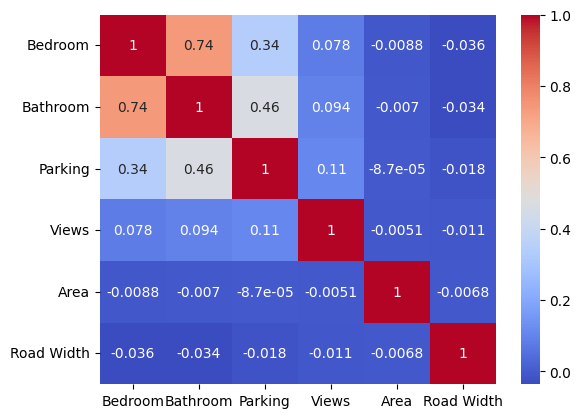

In [179]:
# Calculate the correlation matrix
corr_matrix = X_1.corr()

# Visualize the correlation matrix using a heatmap
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.show()

In [180]:
# # histogram plots
# fig, axs = plt.subplots(X_1.shape[1], figsize=(5, 40))

# for i, column in enumerate(X_1.columns):
#     axs[i].hist(X_1[column])
#     axs[i].set_title(column)

# plt.show()

In [181]:
# for col in X_1.columns:
#     if X_1[col].dtype != object:  # plot only numeric columns
#         fig, ax = plt.subplots()
#         ax.boxplot(X_1[col])
#         ax.set_title(col)
#         plt.show()

## Training

In [182]:
# train test split
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_scaled,y,test_size=0.2,random_state=42)

### Linear Regression

In [183]:
from sklearn.linear_model import LinearRegression

lin_reg_without_regu_model = LinearRegression()
lin_reg_without_regu_model.fit(X_encoded, y)


LinearRegression()

In [184]:
y_pred_train_lin_reg_without_regu = lin_reg_without_regu_model.predict(X_train)
y_pred_test_lin_reg_without_regu = lin_reg_without_regu_model.predict(X_test)

In [185]:
log_dir = "logs/fit/" + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

In [190]:

from sklearn.metrics import mean_squared_error,mean_absolute_error

mse_train_lin_reg_without_regu = mean_squared_error(y_pred_train_lin_reg_without_regu,y_train)
mse_test_lin_reg_without_regu = mean_squared_error(y_pred_test_lin_reg_without_regu,y_test)
print(f'MSE for train set for linear regresson without regularization {mse_train_lin_reg_without_regu}' )
print(f'MSE for test set for linear regresson without regularization {mse_test_lin_reg_without_regu}')
# Log metrics to TensorBoard
with tf.summary.create_file_writer(log_dir).as_default():
    tf.summary.scalar('Train MSE linear regression without regularization', mse_train_lin_reg_without_regu, step=1)
    tf.summary.scalar('Test MSE linear regression without regularization', mse_test_lin_reg_without_regu, step=1)

mae_train_lin_reg_without_regu = mean_absolute_error(y_pred_train_lin_reg_without_regu,y_train)
mae_test_lin_reg_without_regu = mean_absolute_error(y_pred_test_lin_reg_without_regu,y_test)
print(f'mae for train set for linear regresson without regularization {mae_train_lin_reg_without_regu}' )
print(f'mae for test set for linear regresson without regularization {mae_test_lin_reg_without_regu}')
# Log metrics to TensorBoard
with tf.summary.create_file_writer(log_dir).as_default():
    tf.summary.scalar('Train mae linear regression without regularization', mae_train_lin_reg_without_regu, step=1)
    tf.summary.scalar('Test mae linear regression without regularization', mae_test_lin_reg_without_regu, step=1)

MSE for train set for linear regresson without regularization 1.1678054839919736e+26
MSE for test set for linear regresson without regularization 7.0990216235640794e+25
mae for train set for linear regresson without regularization 4422434888464.962
mae for test set for linear regresson without regularization 4564725994640.712


### Lasso Regression


In [192]:
from sklearn.linear_model import Lasso

lasso_model = Lasso(alpha=0.1)
lasso_model.fit(X_train, y_train)

y_pred_train_lasso = lasso_model.predict(X_train)
y_pred_test_lasso = lasso_model.predict(X_test)
mse_train_lasso = mean_squared_error(y_train, y_pred_train_lasso)
mse_test_lasso = mean_squared_error(y_test, y_pred_test_lasso)
print(f"Train MSE lasso: {mse_train_lasso}")
print(f"Test MSE lasso: {mse_test_lasso}")

Train MSE lasso: 6.996815817963528e+25
Test MSE lasso: 2.183038477852152e+24


### XGBoost

In [195]:
import xgboost as xgb

params = {
    "objective": "reg:squarederror",
    "eta": 0.1,
    "max_depth": 6,
    "min_child_weight": 1,
    "subsample": 0.7,
    "colsample_bytree": 0.7,
    "seed": 42,
}

dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

xgb_model = xgb.train(params, dtrain, num_boost_round=100)

y_pred_train_xgb = xgb_model.predict(dtrain)
y_pred_test_xgb = xgb_model.predict(dtest)

mse_train_xgb = mean_squared_error(y_train, y_pred_train_xgb)
mse_test_xgb = mean_squared_error(y_test, y_pred_test_xgb)
print("MSE train xgb:", mse_train_xgb)
print("MSE test xgb:", mse_test_xgb)

MSE train xgb: 1.9114918755269185e+24
MSE test xgb: 1.609143530809109e+25


### Decision Tree


In [197]:
from sklearn.tree import DecisionTreeRegressor

dt_model =  DecisionTreeRegressor(random_state=42)
dt_model.fit(X_train,y_train)


y_pred_train_dt = dt_model.predict(X_train)
y_pred_test_dt = dt_model.predict(X_test)

mse_train_dt = mean_squared_error(y_train, y_pred_train_dt)
mse_test_dt = mean_squared_error(y_test, y_pred_test_dt)
print("MSE train dt:", mse_train_dt)
print("MSE test dt:", mse_test_dt)

MSE train dt: 121073323429.5416
MSE test dt: 6.053675433624042e+25


### SVM

In [189]:
from sklearn.svm import SVR

svr_model = SVR(kernel="linear")
svr_model.fit(X_train, y_train)

y_pred_train_svr = svr_model.predict(X_train)
y_pred_test_svr = svr_model.predict(X_test)

mae_train_svr = mean_absolute_error(y_train, y_pred_train_svr)
mae_test_svr = mean_absolute_error(y_test, y_pred_test_svr)

print(f"Train MAE: {mae_train_svr:.2f}")
print(f"Test MAE: {mae_test_svr:.2f}")
# Log metrics to TensorBoard
with tf.summary.create_file_writer(log_dir).as_default():
    tf.summary.scalar('MAE_train_svr', mae_train_svr, step=1)
    tf.summary.scalar('MAE_test', mae_test_svr, step=1)

mse_train_svr = mean_squared_error(y_train, y_pred_train_svr)
mse_test_svr = mean_squared_error(y_test, y_pred_test_svr)

print(f"Train mse: {mse_train_svr:.2f}")
print(f"Test mse: {mse_test_svr:.2f}")
# Log metrics to TensorBoard
with tf.summary.create_file_writer(log_dir).as_default():
    tf.summary.scalar('mse_train_svr', mse_train_svr, step=1)
    tf.summary.scalar('mse_test', mse_test_svr, step=1)


Train MAE: 504318420575.99
Test MAE: 16991715621.68
Train mse: 71738037284470885485379584.00
Test mse: 127262188424597321285632.00


In [199]:
# svr_model = SVR(kernel="poly")
# svr_model.fit(X_train, y_train)

# y_pred_train_svr = svr_model.predict(X_train)
# y_pred_test_svr = svr_model.predict(X_test)

# mae_train_svr = mean_absolute_error(y_train, y_pred_train_svr)
# mae_test_svr = mean_absolute_error(y_test, y_pred_test_svr)

# print(f"Train MAE: {mae_train_svr:.2f}")
# print(f"Test MAE: {mae_test_svr:.2f}")
# # Log metrics to TensorBoard
# with tf.summary.create_file_writer(log_dir).as_default():
#     tf.summary.scalar('MAE_train_svr', mae_train_svr, step=1)
#     tf.summary.scalar('MAE_test', mae_test_svr, step=1)

# mse_train_svr = mean_squared_error(y_train, y_pred_train_svr)
# mse_test_svr = mean_squared_error(y_test, y_pred_test_svr)

# print(f"Train mse: {mse_train_svr:.2f}")
# print(f"Test mse: {mse_test_svr:.2f}")
# # Log metrics to TensorBoard
# with tf.summary.create_file_writer(log_dir).as_default():
#     tf.summary.scalar('mse_train_svr', mse_train_svr, step=1)
#     tf.summary.scalar('mse_test', mse_test_svr, step=1)


Train MAE: 504318420950.70
Test MAE: 16991716207.41
Train mse: 71738037284480403132907520.00
Test mse: 127262188370372000219136.00


In [200]:
# svr_model = SVR(kernel="sigmoid")
# svr_model.fit(X_train, y_train)

# y_pred_train_svr = svr_model.predict(X_train)
# y_pred_test_svr = svr_model.predict(X_test)

# mae_train_svr = mean_absolute_error(y_train, y_pred_train_svr)
# mae_test_svr = mean_absolute_error(y_test, y_pred_test_svr)

# print(f"Train MAE: {mae_train_svr:.2f}")
# print(f"Test MAE: {mae_test_svr:.2f}")
# # Log metrics to TensorBoard
# with tf.summary.create_file_writer(log_dir).as_default():
#     tf.summary.scalar('MAE_train_svr', mae_train_svr, step=1)
#     tf.summary.scalar('MAE_test', mae_test_svr, step=1)

# mse_train_svr = mean_squared_error(y_train, y_pred_train_svr)
# mse_test_svr = mean_squared_error(y_test, y_pred_test_svr)

# print(f"Train mse: {mse_train_svr:.2f}")
# print(f"Test mse: {mse_test_svr:.2f}")
# # Log metrics to TensorBoard
# with tf.summary.create_file_writer(log_dir).as_default():
#     tf.summary.scalar('mse_train_svr', mse_train_svr, step=1)
#     tf.summary.scalar('mse_test', mse_test_svr, step=1)


Train MAE: 504318421433.57
Test MAE: 16991716251.10
Train mse: 71738037284497668901437440.00
Test mse: 127262188371878275448832.00
